# 📓 Feature Engineering Notebook for DevOps Learners

```Python
# ==============================================================================
# PASO 0: LIMPIEZA DEL DATASET (Valores faltantes y outliers)
# ==============================================================================
import logging
from pathlib import Path

# Configurar logger básico
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def clean_data(df):
    """Limpia el dataset manejando valores faltantes y outliers."""
    logger.info("Limpiando el dataset")
    
    # Hacer una copia para evitar modificar el DataFrame original
    df_cleaned = df.copy()
    
    # Manejo de valores faltantes
    for column in df_cleaned.columns:
        missing_count = df_cleaned[column].isnull().sum()
        if missing_count > 0:
            logger.info(f"Se encontraron {missing_count} valores faltantes en {column}")
            
            # Para columnas numéricas, rellenar con la mediana
            if pd.api.types.is_numeric_dtype(df_cleaned[column]):
                median_value = df_cleaned[column].median()
                df_cleaned[column] = df_cleaned[column].fillna(median_value)
                logger.info(f"Valores faltantes en {column} rellenados con la mediana: {median_value}")
            # Para columnas categóricas, rellenar con la moda
            else:
                mode_value = df_cleaned[column].mode()[0]
                df_cleaned[column] = df_cleaned[column].fillna(mode_value)
                logger.info(f"Valores faltantes en {column} rellenados con la moda: {mode_value}")
    
    # Manejo de outliers en price (variable objetivo)
    # Usando el método IQR para identificar outliers
    Q1 = df_cleaned['price'].quantile(0.25)
    Q3 = df_cleaned['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtrar outliers extremos
    outliers = df_cleaned[(df_cleaned['price'] < lower_bound) | (df_cleaned['price'] > upper_bound)]
    
    if not outliers.empty:
        logger.info(f"Se encontraron {len(outliers)} outliers en la columna price")
        df_cleaned = df_cleaned[(df_cleaned['price'] >= lower_bound) &  (df_cleaned['price'] <= upper_bound)]
        logger.info(f"Outliers eliminados. Nueva forma del dataset: {df_cleaned.shape}")
    
    return df_cleaned

def process_data(input_file, output_file):
    """Pipeline completo de procesamiento de datos."""
    # Crear el directorio de salida si no existe
    output_path = Path(output_file).parent
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Cargar datos
    df = pd.read_csv(input_file)
    logger.info(f"Datos cargados con forma: {df.shape}")
    
    # Limpiar datos
    df_cleaned = clean_data(df)
    
    # Guardar datos procesados
    df_cleaned.to_csv(output_file, index=False)
    logger.info(f"Datos procesados guardados en {output_file}")
    
    return df_cleaned

# Ejemplo de uso antes de la ingeniería de características:
# df = process_data("../data/raw/house_data.csv", "../data/processed/cleaned_house_data.csv")
```

In [1]:
# ==============================================================================
# PASO 1: IMPORTACIÓN DE LIBRERÍAS
# ==============================================================================
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from joblib import dump

# Librerías de Scikit-learn para el preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

print("Librerías importadas.")

Librerías importadas.


In [2]:
# ==============================================================================
# PASO 2: CARGA DE DATOS LIMPIOS
# ==============================================================================
print("\nCargando el dataset limpio desde '../data/processed/cleaned_house_data.csv'...")
try:
    df = pd.read_csv("../data/processed/cleaned_house_data.csv")
    print("Dataset limpio cargado exitosamente.")
except FileNotFoundError:
    print("ERROR: Archivo no encontrado.")
    exit()

print("\nVista previa de los datos:")
print(df.shape)
print(df.head())


Cargando el dataset limpio desde '../data/processed/cleaned_house_data.csv'...
Dataset limpio cargado exitosamente.

Vista previa de los datos:
(77, 7)
     price  sqft  bedrooms  bathrooms    location  year_built  condition
0   495000  1527         2        1.5      Suburb        1956       Good
1   752000  2526         3        2.5    Downtown        1998  Excellent
2   319000  1622         2        1.5       Rural        1975       Fair
3  1210000  3102         4        3.0  Waterfront        2005  Excellent
4   462000  1835         2        2.0       Urban        1982       Good


In [3]:
# ==============================================================================
# PASO 3: INGENIERÍA DE CARACTERÍSTICAS (FEATURE ENGINEERING)
# ==============================================================================
print("\nIniciando la creación de nuevas características...")

# Característica 1: Antigüedad de la propiedad (house_age)
df['house_age'] = datetime.now().year - df['year_built']

# Característica 2: Precio por metro cuadrado (Price per Sqft)
df['price_per_sqft'] = df['price'] / df['sqft']

# Característica 3: Ratio de habitaciones a baños (Bed/Bath Ratio)
# Se manejan posibles divisiones por cero o valores infinitos.
df['bed_bath_ratio'] = df['bedrooms'] / df['bathrooms']
df['bed_bath_ratio'] = df['bed_bath_ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)


# Eliminar columnas originales que ya no son necesarias
df_engineered = df.drop(['year_built'], axis=1)
print("Nuevas características creadas y columna 'year_built' eliminada.")


print("\nVista previa de los datos con nuevas características:")
display(df_engineered.head())

# Estadísticas descriptivas de las nuevas características
print("\nEstadísticas descriptivas de las nuevas características:")
df[['house_age', 'price_per_sqft', 'bed_bath_ratio']].describe()


Iniciando la creación de nuevas características...
Nuevas características creadas y columna 'year_built' eliminada.

Vista previa de los datos con nuevas características:


,price,sqft,bedrooms,bathrooms,location,condition,house_age,price_per_sqft,bed_bath_ratio
0,495000,1527,2,1.5,Suburb,Good,69,324.165029,1.333333
1,752000,2526,3,2.5,Downtown,Excellent,27,297.703880,1.200000
2,319000,1622,2,1.5,Rural,Fair,50,196.670777,1.333333
3,1210000,3102,4,3.0,Waterfront,Excellent,20,390.070922,1.333333
4,462000,1835,2,2.0,Urban,Good,43,251.771117,1.000000



Estadísticas descriptivas de las nuevas características:


,house_age,price_per_sqft,bed_bath_ratio
count,77.000000,77.000000,77.000000
mean,45.974026,255.220441,1.382437
std,17.427273,54.499780,0.263195
min,15.000000,179.761905,1.000000
25%,33.000000,226.829268,1.200000
50%,44.000000,251.904762,1.333333
75%,60.000000,275.193798,1.500000
max,78.000000,390.070922,2.000000



Visualizando la distribución de las nuevas características...


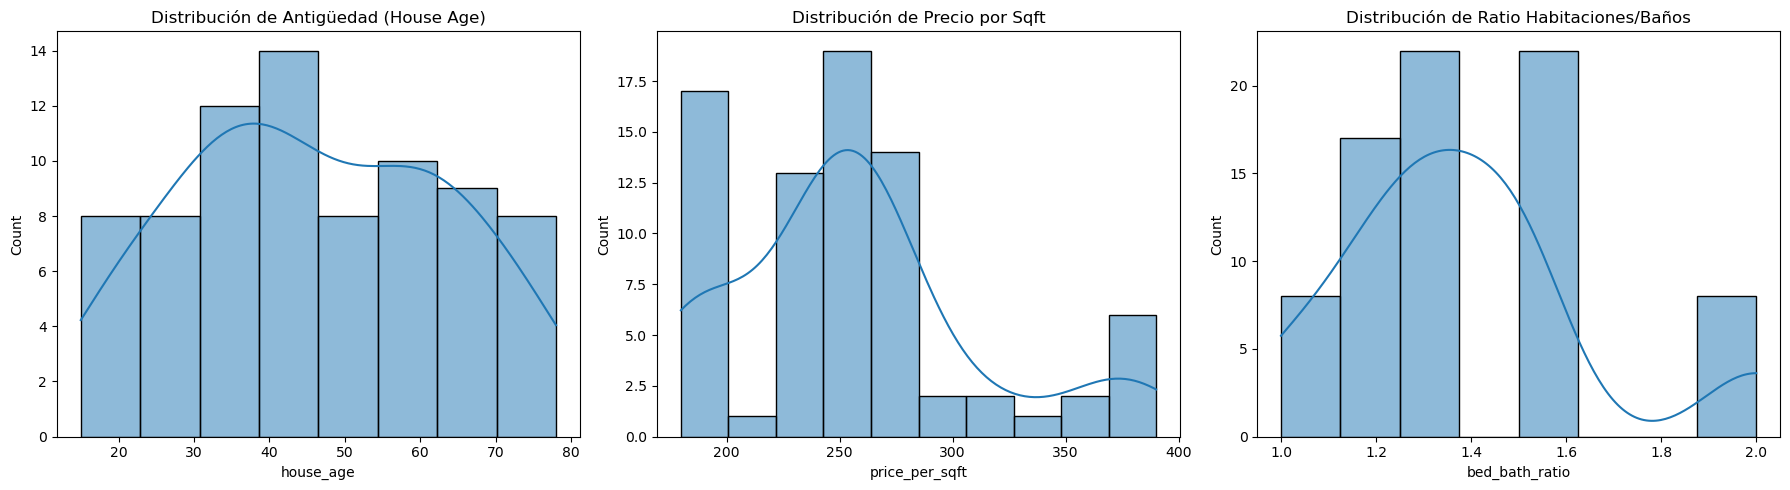

In [4]:
# ==============================================================================
# PASO 4: VISUALIZACIÓN DE LAS NUEVAS CARACTERÍSTICAS
# ==============================================================================
print("\nVisualizando la distribución de las nuevas características...")

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df_engineered['house_age'], kde=True, ax=axs[0])
axs[0].set_title('Distribución de Antigüedad (House Age)')

sns.histplot(df_engineered['price_per_sqft'], kde=True, ax=axs[1])
axs[1].set_title('Distribución de Precio por Sqft')

sns.histplot(df_engineered['bed_bath_ratio'], kde=True, ax=axs[2])
axs[2].set_title('Distribución de Ratio Habitaciones/Baños')

plt.tight_layout()
plt.show()

In [5]:
# 💾 Save Final Engineered Features (Human-Readable CSV)

# Seleccionar las columnas relevantes para guardar
selected_columns = [
    'price', 'sqft', 'bedrooms', 'bathrooms', 'location', 'year_built', 'condition',
    'house_age', 'price_per_sqft', 'bed_bath_ratio'
]

# Guardar las características seleccionadas en un archivo CSV
df[selected_columns].to_csv("../data/processed/data_scientists_features.csv", index=False)
print("Saved human-readable engineered features to ../data/processed/data_scientists_features.csv")

Saved human-readable engineered features to ../data/processed/data_scientists_features.csv


In [6]:
# ==============================================================================
# PASO 5: SEPARACIÓN DE DATOS (FEATURES Y TARGET) Y DIVISIÓN (TRAIN/TEST)
# ==============================================================================
print("\nSeparando características (X) y objetivo (y)")
X = df_engineered.drop('price', axis=1)
y = df_engineered['price']

print("\nDividiendo los datos en conjuntos de entrenamiento (80%) y prueba (20%)")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}.")


Separando características (X) y objetivo (y)

Dividiendo los datos en conjuntos de entrenamiento (80%) y prueba (20%)
Tamaño del conjunto de entrenamiento: (61, 8)
Tamaño del conjunto de prueba: (16, 8).


In [7]:
X_train.head()

,sqft,bedrooms,bathrooms,location,condition,house_age,price_per_sqft,bed_bath_ratio
9,1525,2,1.5,Suburb,Fair,60,221.639344,1.333333
5,1742,2,1.5,Suburb,Good,62,230.195178,1.333333
34,2550,3,2.5,Downtown,Excellent,33,272.549020,1.200000
22,1980,3,2.0,Urban,Good,45,248.484848,1.500000
30,1720,2,1.5,Rural,Fair,63,188.953488,1.333333


In [8]:
# ==============================================================================
# PASO 6: DEFINICIÓN DEL PIPELINE DE PREPROCESAMIENTO
# ==============================================================================
print("\nDefiniendo el pipeline de preprocesamiento para las características...")

# Identificar los tipos de columnas para aplicar las transformaciones correctas
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['location'] # Variable nominal
ordinal_features = ['condition']  # Variable ordinal

# Definir el orden explícito para la variable 'condition'
condition_order = ['Poor', 'Fair', 'Good', 'Excellent']

# Crear el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('ord', OrdinalEncoder(categories=[condition_order]), ordinal_features)
    ],
    remainder='passthrough'
)


Definiendo el pipeline de preprocesamiento para las características...


In [9]:
# ==============================================================================
# PASO 7: APLICACIÓN DEL PIPELINE DE PREPROCESAMIENTO
# ==============================================================================
print("\nAjustando el preprocesador con los datos de entrenamiento...")
X_train_processed_array = preprocessor.fit_transform(X_train)

print("Transformando los datos de prueba con el preprocesador ajustado...")
X_test_processed_array = preprocessor.transform(X_test)

# ==============================================================================
# PASO 8: RECONSTRUCCIÓN DE DATAFRAMES Y GUARDADO SEPARADO
# ==============================================================================
print("\nReconstruyendo los DataFrames de características y guardando los archivos por separado...")

# Obtener los nombres de las nuevas columnas generadas por el preprocesador
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
processed_feature_names = numeric_features + ohe_feature_names.tolist() + ordinal_features

# Convertir los arrays de numpy de vuelta a DataFrames de pandas
X_train_processed = pd.DataFrame(X_train_processed_array, columns=processed_feature_names, index=X_train.index)
X_test_processed = pd.DataFrame(X_test_processed_array, columns=processed_feature_names, index=X_test.index)

# Guardar los DataFrames y Series finales en archivos CSV separados
output_dir = "../data/processed"
X_train_processed.to_csv(os.path.join(output_dir, 'X_train.csv'), index=False)
X_test_processed.to_csv(os.path.join(output_dir, 'X_test.csv'), index=False)
y_train.to_csv(os.path.join(output_dir, 'y_train.csv'), index=False, header=True)
y_test.to_csv(os.path.join(output_dir, 'y_test.csv'), index=False, header=True)
print("Archivos X_train.csv, X_test.csv, y_train.csv, y_test.csv guardados.")

# Guardar el objeto preprocesador ajustado
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)
dump(preprocessor, os.path.join(models_dir, 'preprocessor.joblib'))
print("Objeto preprocesador guardado en '../models/preprocessor.joblib'.")

print("\n--- Proceso de Feature Engineering y Preprocesamiento completado ---")


Ajustando el preprocesador con los datos de entrenamiento...
Transformando los datos de prueba con el preprocesador ajustado...

Reconstruyendo los DataFrames de características y guardando los archivos por separado...
Archivos X_train.csv, X_test.csv, y_train.csv, y_test.csv guardados.
Objeto preprocesador guardado en '../models/preprocessor.joblib'.

--- Proceso de Feature Engineering y Preprocesamiento completado ---


In [10]:
# ✅ 8. Summary
# We:
# - Created domain-informed features: house_age, price_per_sqft, bed_bath_ratio
# - Explored and visualized them
# - Built a preprocessing pipeline using sklearn
# - Saved the preprocessed data and pipeline for downstream ML tasks

# 👨‍🔬 This notebook represents the **data scientist/MLE workflow** for feature engineering,
# before these steps are automated via a script like `engineer.py` for production.

# 📦 Next step: Experimentation to find out the right Algorithm and its Configurations (Hyperparameters)!
